In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import json
import numpy as np
import re
import string
import nltk
import pandas as pd
import matplotlib.pyplot as plt
import regex
from nltk.translate.bleu_score import corpus_bleu
from nltk.tokenize import word_tokenize
from tqdm import tqdm
import unicodedata
import torch.optim as optim
import copy

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
lang_pair="English-Bengali"

In [11]:
input_directory="/kaggle/input/embeddings" 

train_file_path = input_directory+"/train_data.json"
train_data = pd.read_json(train_file_path)

test_file_path = input_directory+"/test_data.json"
test_data = pd.read_json(test_file_path)

for language_pair, language_data in train_data.items():
  print(f"Language Pair: {language_pair}")

for language_pair, language_data in test_data.items():
  print(f"Language Pair: {language_pair}")


source_lang=lang_pair.split("-")[0]
target_lang=lang_pair.split("-")[1]

Language Pair: English-Bengali
Language Pair: English-Hindi
Language Pair: English-Bengali
Language Pair: English-Hindi


In [12]:
def get_sentence_pairs(data,lang_pair,d_type):
    source_sentences=[]
    target_sentences=[]
    id_values=[]
    for language_pair, language_data in data.items():
        if(language_pair == lang_pair):
          print(f"Language Pair: {language_pair}")
          for data_type, data_entries in language_data.items():
              print(f"  Data Type: {data_type}")
              for entry_id, entry_data in data_entries.items():
                  source = entry_data["source"]
                  if "target" in entry_data:
                      target = entry_data["target"]
                    
                  if (data_type == d_type):
                    source_sentences.append(source)
                    if "target" in entry_data:
                        target_sentences.append(target)
                    id_values.append(entry_id)

    return source_sentences,target_sentences,id_values



In [13]:
def create_validation_set(source_sentences_train, target_sentences_train,id_train, val_ratio):
    # Define split ratio
    n_train = len(source_sentences_train)
    n_val = int(n_train * val_ratio)
    
    # Create validation subset
    source_sentences_val = source_sentences_train[:n_val]
    target_sentences_val = target_sentences_train[:n_val]
    id_val = id_train[:n_val]
    
    # Keep the remaining as training
    source_sentences_train = source_sentences_train[n_val:]
    target_sentences_train = target_sentences_train[n_val:]
    id_train = id_train[n_val:]

    return source_sentences_train, target_sentences_train, id_train, source_sentences_val, target_sentences_val, id_val

In [14]:
def preprocess_hindi_text(sentence):
    text = unicodedata.normalize("NFKC", sentence)
    text = re.sub(r"[^\u0900-\u097F\s]", " ", text)  # keep Devanagari + spaces
    text = re.sub(r"[\u0966-\u096F]", " ", text)     # remove Hindi digits

    hindi_only_pattern = re.compile(r'^[\u0900-\u097F]+$')
    tokens = text.strip().split()
    clean_tokens = [tok for tok in tokens if hindi_only_pattern.match(tok)]

    return nltk.word_tokenize(" ".join(clean_tokens))

In [15]:
def preprocess_bengali_text(sentence: str) -> str:
    text = unicodedata.normalize("NFKC", sentence)
    text = re.sub(r"[^\u0980-\u09FF\s]", " ", text)
    bengali_only_pattern = re.compile(r'^[\u0980-\u09FF]+$')
    tokens = text.strip().split()
    clean_tokens = [tok for tok in tokens if bengali_only_pattern.match(tok)]
    return nltk.word_tokenize(" ".join(clean_tokens))

In [19]:
import nltk
from collections import Counter
import unicodedata


def truncate_sentences(sentences,max_length):
    sentences=[sent[:max_length] for sent in sentences]
    return sentences

def preprocess_english_text(sentence):
    text = unicodedata.normalize("NFKC", sentence)
    # Keep only Latin letters and whitespace
    text = re.sub(r"[^A-Za-z\s]", " ", text)
    english_only_pattern = re.compile(r'^[A-Za-z]+$')
    tokens = text.strip().split()
    clean_tokens = [tok for tok in tokens if english_only_pattern.match(tok)]
    return nltk.word_tokenize(" ".join(clean_tokens))

# Tokenization and Lowercasing
def preprocess(sentences,lang):
    if lang=="English":
        tokenized_sentences = [preprocess_english_text(sentence.lower()) for sentence in sentences]
    elif lang=="Hindi":
        tokenized_sentences = [preprocess_hindi_text(sentence.lower()) for sentence in sentences]
    elif lang=="Bengali":
        tokenized_sentences = [preprocess_bengali_text(sentence.lower()) for sentence in sentences]
    else:
        throw ("lang not supported")

    return tokenized_sentences

def encode_and_pad(vocab, sent, max_length):
    sos = [vocab["<SOS>"]]
    eos = [vocab["<EOS>"]]
    pad = [vocab["<PAD>"]]
    unk = vocab["<UNK>"]

    encoded = [vocab.get(w, unk) for w in sent]

    if len(encoded) < max_length - 2:  # -2 for SOS and EOS
        n_pads = max_length - 2 - len(encoded)
        return sos + encoded + eos + pad * n_pads
    else:  # Truncate if longer than max_length
        truncated = encoded[:max_length - 2]
        return sos + truncated + eos

def process_data(train_data, test_data, lang_pair):
    source_sentences_train, target_sentences_train, id_train=get_sentence_pairs(train_data,lang_pair,"Train")
    source_sentences_test, target_sentences_test, id_test=get_sentence_pairs(test_data,lang_pair,"Test")
    print(f"Length of initial training data: {len(source_sentences_train)}")
    print(f"Length of test data: {len(source_sentences_test)}")

    source_sentences_train, target_sentences_train, id_train, source_sentences_val, target_sentences_val, id_val=create_validation_set(
        source_sentences_train, target_sentences_train, id_train,0.01)

    source_tokens_train = preprocess(source_sentences_train,source_lang)
    source_tokens_test = preprocess(source_sentences_test,source_lang)
    source_tokens_val=preprocess(source_sentences_val,source_lang)

    target_tokens_train = preprocess(target_sentences_train,target_lang)
    target_tokens_val=preprocess(target_sentences_val,target_lang)

    
    lengths = [len(sent) for sent in source_tokens_train]
    lengths = np.array(lengths)
    
    print(f"Number of sentences: {len(lengths)}")
    print(f"Average length: {np.mean(lengths):.2f} tokens")
    print(f"Median length: {np.median(lengths)} tokens")
    print(f"Max length: {np.max(lengths)} tokens")
    print(f"Min length: {np.min(lengths)} tokens")
    
    for p in [90, 95, 99]:
        print(f"{p}th percentile length: {np.percentile(lengths, p):.0f} tokens")
    
    
    # Optional: visualize
    plt.hist(lengths, bins=50, color='steelblue', alpha=0.7)
    plt.title("Distribution of Source Sentence Lengths")
    plt.xlabel("Sentence length (tokens)")
    plt.ylabel("Number of sentences")
    plt.show()

    lengths = [len(sent) for sent in target_tokens_train]
    lengths = np.array(lengths)    
    print(f"Number of sentences: {len(lengths)}")
    print(f"Average length: {np.mean(lengths):.2f} tokens")
    print(f"Median length: {np.median(lengths)} tokens")
    print(f"Max length: {np.max(lengths)} tokens")
    print(f"Min length: {np.min(lengths)} tokens")

    
    for p in [90, 95, 99]:
        print(f"{p}th percentile length: {np.percentile(lengths, p):.0f} tokens")

    
    # Optional: visualize
    plt.hist(lengths, bins=50, color='steelblue', alpha=0.7)
    plt.title("Distribution of Source Sentence Lengths")
    plt.xlabel("Sentence length (tokens)")
    plt.ylabel("Number of sentences")
    plt.show()
    

    max_length=20
    source_tokens_train=truncate_sentences(source_tokens_train,max_length)
    target_tokens_train=truncate_sentences(target_tokens_train,max_length)
    source_tokens_val=truncate_sentences(source_tokens_val,max_length)
    target_tokens_val=truncate_sentences(target_tokens_val,max_length)
    source_tokens_test=truncate_sentences(source_tokens_test,max_length)

    print((source_sentences_train[0]))
    print((source_sentences_test[0]))
    print((source_sentences_val[0]))
    print((target_sentences_train[0]))
    print((target_sentences_val[0]))

    print(source_tokens_train[0])
    print(source_tokens_test[0])
    print(source_tokens_val[0])
    print(target_tokens_train[0])
    print(target_tokens_val[0])
    

    
    source_index2word = ["<PAD>", "<SOS>", "<EOS>","<UNK>"]
    target_index2word = ["<PAD>", "<SOS>", "<EOS>","<UNK>"]


    temp=[]
    temp.extend(source_tokens_train)
    all_tokens = [token for sent in temp for token in sent]
    
    token_counts = Counter(all_tokens)    
    temp = [token for token, freq in token_counts.items() if freq >= 1]
    source_index2word.extend(temp)



    temp=[]
    temp.extend(target_tokens_train)
    all_tokens = [token for sent in temp for token in sent]
    token_counts = Counter(all_tokens)
    
    temp = [token for token, freq in token_counts.items() if freq >= 1]
    target_index2word.extend(temp)
    
    source_word2index = {token: idx for idx, token in enumerate(source_index2word)}
    target_word2index = {token: idx for idx, token in enumerate(target_index2word)}

    print(f"max seq length used for sentences: {max_length}")
    source_train_encoded = [encode_and_pad(source_word2index, sent, max_length) for sent in source_tokens_train]
    source_val_encoded = [encode_and_pad(source_word2index, sent, max_length) for sent in source_tokens_val]
    source_test_encoded = [encode_and_pad(source_word2index, sent, max_length) for sent in source_tokens_test]
    
    target_train_encoded = [encode_and_pad(target_word2index, sent, max_length) for sent in target_tokens_train]
    target_val_encoded = [encode_and_pad(target_word2index, sent, max_length) for sent in target_tokens_val]
    
    print(source_train_encoded[1])
    
    batch_size = 64
    
    train_x = np.array(source_train_encoded)
    train_y = np.array(target_train_encoded)
    
    val_x = np.array(source_val_encoded)
    val_y = np.array(target_val_encoded)
    
    test_x = np.array(source_test_encoded)
    
    
    
    train_ds = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
    val_ds = TensorDataset(torch.from_numpy(val_x))
    test_ds = TensorDataset(torch.from_numpy(test_x))
    
    train_dl = DataLoader(train_ds, shuffle=True, batch_size=batch_size, drop_last=True)
    return train_dl, val_ds, test_ds, source_word2index, source_index2word, target_word2index, target_index2word,target_sentences_val

Language Pair: English-Bengali
  Data Type: Train
Language Pair: English-Bengali
  Data Type: Test
Length of initial training data: 68849
Length of test data: 19672
Number of sentences: 68161
Average length: 16.11 tokens
Median length: 15.0 tokens
Max length: 87 tokens
Min length: 0 tokens
90th percentile length: 27 tokens
95th percentile length: 31 tokens
99th percentile length: 41 tokens


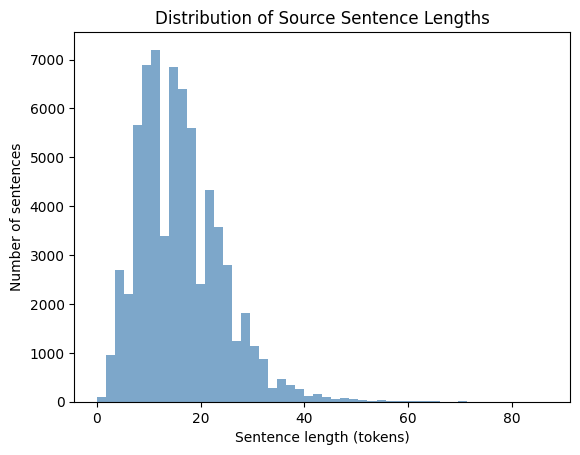

Number of sentences: 68161
Average length: 14.00 tokens
Median length: 13.0 tokens
Max length: 77 tokens
Min length: 0 tokens
90th percentile length: 23 tokens
95th percentile length: 27 tokens
99th percentile length: 35 tokens


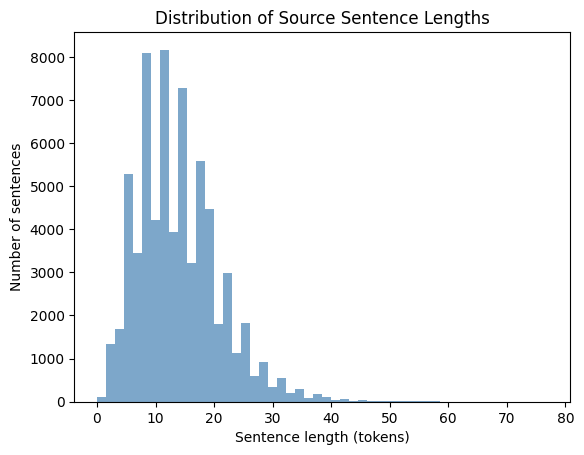

i need a meeting to be schedule with this person
current events
Do not forget to visit the point where the Narmada flowing through the marble rocks interchanges its calmness and serenity into insouciance.
আমি এই ব্যক্তির সাথে একটি মিটিং চাই
এই জায়গাগুলো দেখতে ভুলো না যেখানে নর্মদা নদী মার্বেল পাথরের পাহাড়ের মধ্য দিয়ে প্রবাহিত হচ্ছে এবং নিজের শান্তি ও সৌন্দর্যকে অনাসক্তিতে পরিণত করছে।
['i', 'need', 'a', 'meeting', 'to', 'be', 'schedule', 'with', 'this', 'person']
['current', 'events']
['do', 'not', 'forget', 'to', 'visit', 'the', 'point', 'where', 'the', 'narmada', 'flowing', 'through', 'the', 'marble', 'rocks', 'interchanges', 'its', 'calmness', 'and', 'serenity']
['আমি', 'এই', 'ব্যক্তির', 'সাথে', 'একটি', 'মিটিং', 'চাই']
['এই', 'জায়গাগুলো', 'দেখতে', 'ভুলো', 'না', 'যেখানে', 'নর্মদা', 'নদী', 'মার্বেল', 'পাথরের', 'পাহাড়ের', 'মধ্য', 'দিয়ে', 'প্রবাহিত', 'হচ্ছে', 'এবং', 'নিজের', 'শান্তি', 'ও', 'সৌন্দর্যকে']
max seq length used for sentences: 20
[1, 14, 15, 16, 8, 17, 2, 0, 0, 0, 0, 0, 0, 

In [20]:
train_dl, val_ds, test_ds, source_word2index, source_index2word, target_word2index, target_index2word,target_sentences_val=process_data(train_data,test_data,lang_pair)

In [21]:
import torch
import torch.nn as nn
import math
import torch.nn.functional as F


class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]
        return x


class TransformerModel(nn.Module):
    def __init__(self, src_embedding_layer, tgt_embedding_layer, d_model, nhead, num_encoder_layers, num_decoder_layers, target_vocab_size):
        super().__init__()
        self.src_embedding = src_embedding_layer   # encoder embeddings
        self.tgt_embedding = tgt_embedding_layer   # decoder embeddings

        if src_embedding_layer.embedding_dim!=d_model:  # since pre trained embeddings size is 300, through this we map to arbitrary length
            self.src_proj = nn.Linear(src_embedding_layer.embedding_dim, d_model, bias=False)
            self.tgt_proj = nn.Linear(tgt_embedding_layer.embedding_dim, d_model, bias=False)

        self.pos_encoder = PositionalEncoding(d_model)
        self.dropout = nn.Dropout(p=0.2) 
        
        self.transformer = nn.Transformer(
            d_model=d_model, nhead=nhead,
            num_encoder_layers=num_encoder_layers,
            num_decoder_layers=num_decoder_layers,
            batch_first=True,
            dropout=0.2,
            dim_feedforward=d_model*4,
            #norm_first=True,
            #activation=F.gelu 
        
        )
        self.fc_out = nn.Linear(d_model, target_vocab_size)
        self.d_model=d_model

        
        

    def make_tgt_mask(self, tgt):
        '''
        Creates a triangular mask for the target sequence.
        Prevents decoder from looking ahead.
        '''
        seq_len = tgt.size(1)
        mask = torch.triu(torch.ones((seq_len, seq_len), device=tgt.device), diagonal=1)
        mask = mask.masked_fill(mask == 1, float('-inf'))
        return mask

    def forward(self, src, tgt):
        value = getattr(self, 'src_proj', None)
        if value is None:
            src_emb = self.src_embedding(src)
            tgt_emb = self.tgt_embedding(tgt)
        else:
            src_emb = self.src_proj(self.src_embedding(src)) 
            tgt_emb = self.tgt_proj(self.tgt_embedding(tgt)) 

        src_emb = self.pos_encoder(src_emb)
        tgt_emb = self.pos_encoder(tgt_emb)
  
        src_emb = self.dropout(src_emb) 
        tgt_emb = self.dropout(tgt_emb) 

        tgt_mask = self.make_tgt_mask(tgt)

        output = self.transformer(
            src_emb, tgt_emb,
            src_key_padding_mask=(src==0),   
            tgt_key_padding_mask=(tgt==0),   
            tgt_mask=tgt_mask                 
        )
        return self.fc_out(output)


In [23]:
import numpy as np

def get_embeddings(embedding_dim,source_word2index, target_word2index):
    source_embedding_matrix = np.random.normal(
        loc=0.0,
        scale=1/np.sqrt(embedding_dim),
        size=(len(source_word2index), embedding_dim)
    ).astype(np.float32)
    
    target_embedding_matrix = np.random.normal(
        loc=0.0,
        scale=1/np.sqrt(embedding_dim),
        size=(len(target_word2index), embedding_dim)
    ).astype(np.float32)

    glove = {}
    with open(f"/kaggle/input/embeddings/glove.6B.{embedding_dim}d.txt", "r", encoding="utf8") as f:
        for line in f:
            parts = line.strip().split()
            word = parts[0]
            vector = np.asarray(parts[1:], dtype="float32")
            glove[word] = vector
    
    
    i=0
    j=0
    
    for word, idx in source_word2index.items():
        if word in glove:
            i+=1
            source_embedding_matrix[idx] = glove[word]
        else:
            j+=1

    print(f"Number of source words found: {i}")
    print(f"Number of source words missing: {j}")

    fasttext = {}
    embeddings_file=None

    # we use fast text wiki embeddings for hindi but use common crawl for Bengali since
    # wiki version has lot of missing words
    
    if target_lang=="Hindi":
        embeddings_file="/kaggle/input/embeddings/wiki.hi.vec"
    elif target_lang=="Bengali":
        embeddings_file="/kaggle/input/embeddings/cc.bn.300.vec"
        
    with open(embeddings_file, "r", encoding="utf8") as f:
        for line in f:
            try:
                parts = line.strip().split()
                word = parts[0]
                vector = np.asarray(parts[1:], dtype="float32")
                fasttext[word] = vector
            except:
                continue

    i=0
    j=0
    for word, idx in target_word2index.items():
        if word in fasttext:
            target_embedding_matrix[idx] = fasttext[word]
            i+=1
        else:
            j+=1
            
    print(f"Number of target words found: {i}")
    print(f"Number of target words missing: {j}")
    return source_embedding_matrix, target_embedding_matrix


def calculate_bleu_score(target_lang):
    target_tokens_val=preprocess(target_sentences_val,target_lang)
    references = [[tokens] for tokens in target_tokens_val]
    hypotheses = [word_tokenize(hyp) for hyp in val_outs]
    bleu_score = corpus_bleu(references, hypotheses)    
    print(f"BLEU score: {bleu_score}")
    return bleu_score


In [24]:
# beam search based inferencing
def infer_transformer(
    model,
    test_ds,
    target_index2word,
    target_word2index,
    device,
    beam_size: int = 5,
    max_target_len: int = 20,
    length_penalty: float = 1.0,
):
    PAD_IDX = 0
    SOS_IDX = target_word2index["<SOS>"]
    EOS_IDX = target_word2index["<EOS>"]

    model.eval()
    outputs = []

    for i in tqdm(range(len(test_ds))):
        src_tensor = test_ds[i][0].unsqueeze(0).to(device).long()
        src_mask = (src_tensor == PAD_IDX).to(device)

        # Encode source sequence once
        with torch.no_grad():
            projection = getattr(model, "src_proj", None)
            if projection is None:
                src_emb = model.pos_encoder(model.src_embedding(src_tensor))
            else:
                src_emb = model.pos_encoder(model.src_proj(model.src_embedding(src_tensor)))

            memory = model.transformer.encoder(src_emb, src_key_padding_mask=src_mask)

        # Initialize beam
        beams = [(torch.tensor([[SOS_IDX]], device=device), 0.0)]

        for _ in range(max_target_len):
            new_beams = []
            for seq, score in beams:
                if seq[0, -1].item() == EOS_IDX:
                    new_beams.append((seq, score))
                    continue

                tgt_mask = model.make_tgt_mask(seq)
                tgt_pad_mask = (seq == PAD_IDX).to(device)

                with torch.no_grad():
                    if projection is None:
                        tgt_emb = model.pos_encoder(model.tgt_embedding(seq))
                    else:
                        tgt_emb = model.pos_encoder(model.tgt_proj(model.tgt_embedding(seq)))

                    decoder_out = model.transformer.decoder(
                        tgt_emb,
                        memory,
                        tgt_mask=tgt_mask,
                        tgt_key_padding_mask=tgt_pad_mask,
                        memory_key_padding_mask=src_mask,
                    )
                    logits = model.fc_out(decoder_out[:, -1, :])
                    log_probs = F.log_softmax(logits, dim=-1)
                    topk_log_probs, topk_indices = torch.topk(log_probs, beam_size)

                    for k in range(beam_size):
                        next_token = topk_indices[:, k].unsqueeze(1)
                        new_seq = torch.cat([seq, next_token], dim=1)
                        new_score = score + topk_log_probs[0, k].item()
                        new_beams.append((new_seq, new_score))

            beams = sorted(
                new_beams,
                key=lambda x: x[1] / (len(x[0][0]) ** length_penalty),
                reverse=True,
            )[:beam_size]

            if all(seq[0, -1].item() == EOS_IDX for seq, _ in beams):
                break

        best_seq, best_score = max(
            beams, key=lambda x: x[1] / (len(x[0][0]) ** length_penalty)
        )

        pred_ids = best_seq[0].squeeze(0).tolist()[1:]  # remove SOS
        pred_tokens = [
            target_index2word[idx]
            for idx in pred_ids
            if idx not in [PAD_IDX, EOS_IDX]
        ]
        outputs.append(" ".join(pred_tokens))
        if i%500==0:
            import pickle
            print(i)
            with open("my_list.pkl", "wb") as f:  
                pickle.dump(outputs, f)

    return outputs


In [25]:
# greedy decoding
def infer_greedy(model, test_ds, target_index2word, target_word2index, device, target_length=20):
    PAD_IDX = 0 
    SOS_IDX = target_word2index['<SOS>']
    EOS_IDX = target_word2index['<EOS>'] 
    model.eval()
    val_outs = []
    
    for i in tqdm(range(len(test_ds))):
        # Ensure input tensor is long (integer) type, which nn.Embedding expects
        src_tensor = test_ds[i][0].unsqueeze(dim=0).to(device).long()
        
        tgt_input_sequence = torch.tensor([[SOS_IDX]], dtype=torch.long, device=device) # [1, 1]
        
        src_padding_mask = (src_tensor == PAD_IDX).to(device)
        with torch.set_grad_enabled(False):
            projection = getattr(model, 'src_proj', None)
            if projection is None:
                src_emb = model.pos_encoder(model.src_embedding(src_tensor))
            else:
                src_emb = model.pos_encoder(model.src_proj(model.src_embedding(src_tensor)))
            
            memory = model.transformer.encoder(
                src_emb,
                src_key_padding_mask=src_padding_mask
            )
            
            result_tokens = []
            
            for _ in range(target_length - 1): 
                tgt_mask = model.make_tgt_mask(tgt_input_sequence)                 
                tgt_padding_mask = (tgt_input_sequence == PAD_IDX).to(device) 
                
                if projection is None:
                    tgt_emb = model.pos_encoder(model.tgt_embedding(tgt_input_sequence))
                else:
                    tgt_emb = model.pos_encoder(model.tgt_proj(model.tgt_embedding(tgt_input_sequence)))
                    
                decoder_output = model.transformer.decoder(
                    tgt_emb, 
                    memory,
                    tgt_mask=tgt_mask,
                    tgt_key_padding_mask=tgt_padding_mask,
                    memory_key_padding_mask=src_padding_mask
                )

                last_token_output = model.fc_out(decoder_output[:, -1, :]) 
                best_token_id = last_token_output.argmax(dim=-1)
                predicted_token = best_token_id.item()
                
                if predicted_token == EOS_IDX:
                    break
                
                result_tokens.append(target_index2word[predicted_token])
                tgt_input_sequence = torch.cat(
                    [tgt_input_sequence, best_token_id.unsqueeze(dim=0)], dim=1
                ) 

        val_outs.append(" ".join(result_tokens))
        
    return val_outs

In [26]:
# Convert to torch embeddings

use_glove_embeddings=True
embedding_size=300


if use_glove_embeddings:
    print("Using pre trained embeddings")
    source_embedding_matrix,target_embedding_matrix=get_embeddings(embedding_size,source_word2index, target_word2index)
    src_embedding_layer = nn.Embedding.from_pretrained(torch.from_numpy(source_embedding_matrix),freeze=False)
    tgt_embedding_layer = nn.Embedding.from_pretrained(torch.from_numpy(target_embedding_matrix),freeze=False)

else:
    print("Using random embeddings")
    src_embedding_layer = nn.Embedding(len(source_word2index), embedding_size)
    tgt_embedding_layer = nn.Embedding(len(target_word2index),sizebedding_size)

 
# Hyperparameters
d_model = 512                
nhead = 8
num_encoder_layers = 3
num_decoder_layers = 3
num_epochs = 60
pad_idx = 0

# Initialize the model
transformer_model = TransformerModel(
    target_vocab_size=len(target_index2word),
    d_model=d_model,
    nhead=nhead,
    num_encoder_layers=num_encoder_layers,
    num_decoder_layers=num_decoder_layers,
    src_embedding_layer=src_embedding_layer,
    tgt_embedding_layer=tgt_embedding_layer
).to(device)
print(transformer_model)

Using pre trained embeddings
Number of source words found: 35974
Number of source words missing: 10706
Number of target words found: 60215
Number of target words missing: 27684
TransformerModel(
  (src_embedding): Embedding(46680, 300)
  (tgt_embedding): Embedding(87899, 300)
  (src_proj): Linear(in_features=300, out_features=512, bias=False)
  (tgt_proj): Linear(in_features=300, out_features=512, bias=False)
  (pos_encoder): PositionalEncoding()
  (dropout): Dropout(p=0.2, inplace=False)
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0-2): 3 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
          )
          (linear1): Linear(in_features=512, out_features=2048, bias=True)
          (dropout): Dropout(p=0.2, inplace=False)
          (linear2): Linear(in_features=2048, out_features=512, bias=True)
          (

In [27]:

criterion = nn.CrossEntropyLoss(ignore_index=pad_idx)

from torch.optim import Adam
def get_lr(step, d_model=512, warmup_steps=4000):
    step = max(step, 1)
    return (1/2)*(d_model ** -0.5) * min(step ** -0.5, step * (warmup_steps ** -1.5))


optimizer = Adam(
    transformer_model.parameters(),
    lr=0,                   # No base LR, we use warm up scheduling
    betas=(0.9, 0.98),
    eps=1e-9
)

best_model_greedy=None
previous_best_score_greedy=0
best_model_beam=None
previous_best_score_beam=0

processed_batches=0
for epoch in range(num_epochs):
    transformer_model.train()
    total_loss = 0

    for src_batch, tgt_batch in train_dl:  
        src_batch = src_batch.to(device)
        tgt_batch = tgt_batch.to(device)        

        # Shift target for input and output
        tgt_input = tgt_batch[:, :-1]  # input to decoder
        tgt_output = tgt_batch[:, 1:]  # expected output

        optimizer.zero_grad()

        # Forward pass
        output = transformer_model(src_batch, tgt_input)

        output = output.reshape(-1, output.size(-1))
        tgt_output = tgt_output.reshape(-1)
        
        processed_batches += 1
        lr = get_lr(processed_batches)
        
        for param_group in optimizer.param_groups:
            param_group["lr"] = lr

        loss = criterion(output, tgt_output)
        loss.backward()

        torch.nn.utils.clip_grad_norm_(transformer_model.parameters(), max_norm=1.0)
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(train_dl):.4f}, lr: {lr}")
    if epoch >=19:        
        val_outs=infer_greedy(transformer_model, val_ds, target_index2word, target_word2index,device)
        bleu_score=calculate_bleu_score(target_lang)

        if bleu_score*100 - previous_best_score_greedy*100>=0.25:
            print("saving new model greedy ")
            transformer_model.cpu()
            best_model_greedy=copy.deepcopy(transformer_model)
            transformer_model.to(device)
            previous_best_score_greedy=bleu_score
        
        val_outs=infer_transformer(transformer_model, val_ds, target_index2word, target_word2index,device)
        bleu_score=calculate_bleu_score(target_lang)
        if bleu_score*100 - previous_best_score_beam*100>=0.25:
            print("saving new model beam")
            transformer_model.cpu()
            best_model_beam=copy.deepcopy(transformer_model)
            transformer_model.to(device)
            previous_best_score_beam=bleu_score

/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch [1/60], Loss: 8.8252, lr: 9.302392172020611e-05
Epoch [2/60], Loss: 7.4842, lr: 0.00018604784344041221
Epoch [3/60], Loss: 6.9474, lr: 0.00027907176516061834
Epoch [4/60], Loss: 6.4790, lr: 0.0003385557734511246
Epoch [5/60], Loss: 6.0306, lr: 0.0003028134894446933
Epoch [6/60], Loss: 5.6726, lr: 0.00027642963147618506
Epoch [7/60], Loss: 5.3893, lr: 0.0002559241089933713
Epoch [8/60], Loss: 5.1545, lr: 0.00023939508321714674
Epoch [9/60], Loss: 4.9587, lr: 0.00022570384896741642
Epoch [10/60], Loss: 4.7875, lr: 0.00021412147182110365
Epoch [11/60], Loss: 4.6377, lr: 0.0002041568129356266
Epoch [12/60], Loss: 4.5046, lr: 0.00019546526693770878
Epoch [13/60], Loss: 4.3811, lr: 0.00018779695396652305
Epoch [14/60], Loss: 4.2721, lr: 0.00018096567293833795
Epoch [15/60], Loss: 4.1707, lr: 0.00017482944964514356
Epoch [16/60], Loss: 4.0757, lr: 0.0001692778867255623
Epoch [17/60], Loss: 3.9880, lr: 0.0001642236722472553
Epoch [18/60], Loss: 3.9020, lr: 0.00015959672214476447
Epoch [1

  0%|          | 0/688 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:508: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. We recommend specifying layout=torch.jagged when constructing a nested tensor, as this layout receives active development, has better operator coverage, and works with torch.compile. (Triggered internally at /pytorch/aten/src/ATen/NestedTensorImpl.cpp:178.)
  output = torch._nested_tensor_from_mask(
100%|██████████| 688/688 [00:48<00:00, 14.05it/s]


BLEU score: 0.05979342265829089
saving new model greedy 


  0%|          | 1/688 [00:00<05:35,  2.05it/s]

0


 73%|███████▎  | 501/688 [02:54<01:12,  2.59it/s]

500


100%|██████████| 688/688 [04:00<00:00,  2.87it/s]


BLEU score: 0.06908332169460629
saving new model beam
Epoch [21/60], Loss: 3.6927, lr: 0.00014775785321943804


100%|██████████| 688/688 [00:48<00:00, 14.30it/s]


BLEU score: 0.06858721760104011
saving new model greedy 


  0%|          | 1/688 [00:00<04:47,  2.39it/s]

0


 73%|███████▎  | 501/688 [02:52<01:12,  2.59it/s]

500


100%|██████████| 688/688 [03:56<00:00,  2.91it/s]


BLEU score: 0.07386135859971954
saving new model beam
Epoch [22/60], Loss: 3.6348, lr: 0.00014436066685221506


100%|██████████| 688/688 [00:48<00:00, 14.06it/s]


BLEU score: 0.06895023950915495


  0%|          | 1/688 [00:00<04:42,  2.43it/s]

0


 73%|███████▎  | 501/688 [02:56<01:13,  2.56it/s]

500


100%|██████████| 688/688 [04:02<00:00,  2.84it/s]


BLEU score: 0.07571317942036916
Epoch [23/60], Loss: 3.5908, lr: 0.000141187517453602


100%|██████████| 688/688 [00:47<00:00, 14.41it/s]


BLEU score: 0.06731265280076544


  0%|          | 1/688 [00:00<04:41,  2.44it/s]

0


 73%|███████▎  | 501/688 [02:52<01:11,  2.60it/s]

500


100%|██████████| 688/688 [03:56<00:00,  2.91it/s]


BLEU score: 0.07719351402368492
saving new model beam
Epoch [24/60], Loss: 3.5557, lr: 0.00013821481573809253


100%|██████████| 688/688 [00:48<00:00, 14.06it/s]


BLEU score: 0.0632547733182925


  0%|          | 1/688 [00:00<04:40,  2.45it/s]

0


 73%|███████▎  | 501/688 [02:56<01:13,  2.54it/s]

500


100%|██████████| 688/688 [04:01<00:00,  2.84it/s]


BLEU score: 0.07103862161385728
Epoch [25/60], Loss: 3.5241, lr: 0.00013542230938044984


100%|██████████| 688/688 [00:48<00:00, 14.27it/s]


BLEU score: 0.06685843922661278


  0%|          | 1/688 [00:00<04:34,  2.50it/s]

0


 73%|███████▎  | 501/688 [02:54<01:12,  2.58it/s]

500


100%|██████████| 688/688 [03:59<00:00,  2.87it/s]


BLEU score: 0.0754565936152657
Epoch [26/60], Loss: 3.4900, lr: 0.00013279249963590634


100%|██████████| 688/688 [00:48<00:00, 14.19it/s]


BLEU score: 0.06844001020484587


  0%|          | 1/688 [00:00<04:09,  2.76it/s]

0


 73%|███████▎  | 501/688 [02:56<01:12,  2.56it/s]

500


100%|██████████| 688/688 [04:01<00:00,  2.85it/s]


BLEU score: 0.0741612558597965
Epoch [27/60], Loss: 3.4589, lr: 0.0001303101779584725


100%|██████████| 688/688 [00:48<00:00, 14.24it/s]


BLEU score: 0.06586275953060006


  0%|          | 1/688 [00:00<04:40,  2.45it/s]

0


 73%|███████▎  | 501/688 [02:54<01:10,  2.65it/s]

500


100%|██████████| 688/688 [03:58<00:00,  2.88it/s]


BLEU score: 0.0760834986301127
Epoch [28/60], Loss: 3.4211, lr: 0.00012796205449668564


100%|██████████| 688/688 [00:48<00:00, 14.12it/s]


BLEU score: 0.0632306942976083


  0%|          | 1/688 [00:00<04:41,  2.44it/s]

0


 73%|███████▎  | 501/688 [02:58<01:13,  2.54it/s]

500


100%|██████████| 688/688 [04:03<00:00,  2.82it/s]


BLEU score: 0.07674407417677898
Epoch [29/60], Loss: 3.3836, lr: 0.00012573645768559989


100%|██████████| 688/688 [00:49<00:00, 13.99it/s]


BLEU score: 0.06812087417348184


  0%|          | 1/688 [00:00<05:11,  2.21it/s]

0


 73%|███████▎  | 501/688 [02:58<01:13,  2.56it/s]

500


100%|██████████| 688/688 [04:05<00:00,  2.81it/s]


BLEU score: 0.0730447940724502
Epoch [30/60], Loss: 3.3447, lr: 0.00012362308939519308


100%|██████████| 688/688 [00:49<00:00, 14.00it/s]


BLEU score: 0.06543632048797715


  0%|          | 1/688 [00:00<04:41,  2.44it/s]

0


 73%|███████▎  | 501/688 [02:57<01:11,  2.61it/s]

500


100%|██████████| 688/688 [04:04<00:00,  2.82it/s]


BLEU score: 0.07824205995099587
Epoch [31/60], Loss: 3.3111, lr: 0.00012161282388719524


100%|██████████| 688/688 [00:48<00:00, 14.24it/s]


BLEU score: 0.06835737582864002


  0%|          | 1/688 [00:00<04:43,  2.42it/s]

0


 73%|███████▎  | 501/688 [02:55<01:11,  2.61it/s]

500


100%|██████████| 688/688 [04:00<00:00,  2.86it/s]


BLEU score: 0.07752909238435622
Epoch [32/60], Loss: 3.2748, lr: 0.00011969754160857337


100%|██████████| 688/688 [00:48<00:00, 14.19it/s]


BLEU score: 0.07032853328154878


  0%|          | 1/688 [00:00<04:55,  2.32it/s]

0


 73%|███████▎  | 501/688 [02:56<01:13,  2.53it/s]

500


100%|██████████| 688/688 [04:01<00:00,  2.85it/s]


BLEU score: 0.07856920920128069
Epoch [33/60], Loss: 3.2427, lr: 0.0001178699909052801


100%|██████████| 688/688 [00:48<00:00, 14.22it/s]


BLEU score: 0.07181332730990413
saving new model greedy 


  0%|          | 1/688 [00:00<04:26,  2.58it/s]

0


 73%|███████▎  | 501/688 [02:54<01:13,  2.54it/s]

500


100%|██████████| 688/688 [03:59<00:00,  2.87it/s]


BLEU score: 0.07886491983606674
Epoch [34/60], Loss: 3.2111, lr: 0.00011612367227739127


100%|██████████| 688/688 [00:47<00:00, 14.45it/s]


BLEU score: 0.07335986418910186


  0%|          | 1/688 [00:00<04:06,  2.78it/s]

0


 73%|███████▎  | 501/688 [02:53<01:13,  2.55it/s]

500


100%|██████████| 688/688 [03:58<00:00,  2.89it/s]


BLEU score: 0.08131116389133082
saving new model beam
Epoch [35/60], Loss: 3.1808, lr: 0.00011445274095804868


100%|██████████| 688/688 [00:48<00:00, 14.15it/s]


BLEU score: 0.06969940872309148


  0%|          | 1/688 [00:00<04:42,  2.43it/s]

0


 73%|███████▎  | 501/688 [02:56<01:13,  2.54it/s]

500


100%|██████████| 688/688 [04:02<00:00,  2.84it/s]


BLEU score: 0.07735783984236529
Epoch [36/60], Loss: 3.1497, lr: 0.00011285192448370821


100%|██████████| 688/688 [00:48<00:00, 14.10it/s]


BLEU score: 0.06968895966961841


  0%|          | 1/688 [00:00<04:31,  2.53it/s]

0


 73%|███████▎  | 501/688 [02:56<01:13,  2.55it/s]

500


100%|██████████| 688/688 [04:02<00:00,  2.83it/s]


BLEU score: 0.07890076238840775
Epoch [37/60], Loss: 3.1215, lr: 0.00011131645260349371


100%|██████████| 688/688 [00:47<00:00, 14.51it/s]


BLEU score: 0.07123805557960097


  0%|          | 1/688 [00:00<04:23,  2.61it/s]

0


 73%|███████▎  | 501/688 [02:53<01:11,  2.60it/s]

500


100%|██████████| 688/688 [03:57<00:00,  2.90it/s]


BLEU score: 0.07820450217363359
Epoch [38/60], Loss: 3.0942, lr: 0.00010984199740253184


100%|██████████| 688/688 [00:48<00:00, 14.22it/s]


BLEU score: 0.06890677024204454


  0%|          | 1/688 [00:00<04:14,  2.70it/s]

0


 73%|███████▎  | 501/688 [02:54<01:09,  2.69it/s]

500


100%|██████████| 688/688 [04:00<00:00,  2.86it/s]


BLEU score: 0.07728544058640076
Epoch [39/60], Loss: 3.0683, lr: 0.00010842462192556383


100%|██████████| 688/688 [00:47<00:00, 14.42it/s]


BLEU score: 0.0698340485799647


  0%|          | 1/688 [00:00<04:36,  2.48it/s]

0


 73%|███████▎  | 501/688 [02:52<01:12,  2.60it/s]

500


100%|██████████| 688/688 [03:56<00:00,  2.91it/s]


BLEU score: 0.07802221234002324
Epoch [40/60], Loss: 3.0419, lr: 0.00010706073591055182


100%|██████████| 688/688 [00:48<00:00, 14.18it/s]


BLEU score: 0.07035452694687025


  0%|          | 1/688 [00:00<04:17,  2.67it/s]

0


 73%|███████▎  | 501/688 [02:55<01:11,  2.60it/s]

500


100%|██████████| 688/688 [04:01<00:00,  2.85it/s]


BLEU score: 0.08147004499655251
Epoch [41/60], Loss: 3.0184, lr: 0.00010574705749793759


100%|██████████| 688/688 [00:48<00:00, 14.04it/s]


BLEU score: 0.06985465697366088


  0%|          | 1/688 [00:00<04:42,  2.43it/s]

0


 73%|███████▎  | 501/688 [02:56<01:13,  2.54it/s]

500


100%|██████████| 688/688 [04:02<00:00,  2.84it/s]


BLEU score: 0.07743572235402832
Epoch [42/60], Loss: 2.9938, lr: 0.00010448057998503117


100%|██████████| 688/688 [00:48<00:00, 14.25it/s]


BLEU score: 0.0707287351262969


  0%|          | 1/688 [00:00<04:26,  2.58it/s]

0


 73%|███████▎  | 501/688 [02:56<01:12,  2.59it/s]

500


100%|██████████| 688/688 [04:02<00:00,  2.84it/s]


BLEU score: 0.07984543430493339
Epoch [43/60], Loss: 2.9687, lr: 0.00010325854285829139


100%|██████████| 688/688 [00:48<00:00, 14.29it/s]


BLEU score: 0.07226151783190321


  0%|          | 1/688 [00:00<04:57,  2.31it/s]

0


 73%|███████▎  | 501/688 [02:56<01:12,  2.57it/s]

500


100%|██████████| 688/688 [04:01<00:00,  2.85it/s]


BLEU score: 0.07991527303373165
Epoch [44/60], Loss: 2.9477, lr: 0.0001020784064678133


100%|██████████| 688/688 [00:48<00:00, 14.13it/s]


BLEU score: 0.07266823002900202


  0%|          | 1/688 [00:00<04:40,  2.45it/s]

0


 73%|███████▎  | 501/688 [02:55<01:11,  2.62it/s]

500


100%|██████████| 688/688 [04:01<00:00,  2.85it/s]


BLEU score: 0.0811137285619807
Epoch [45/60], Loss: 2.9267, lr: 0.00010093782981489776


100%|██████████| 688/688 [00:48<00:00, 14.33it/s]


BLEU score: 0.07349004762407453


  0%|          | 1/688 [00:00<04:36,  2.48it/s]

0


 73%|███████▎  | 501/688 [02:55<01:10,  2.64it/s]

500


100%|██████████| 688/688 [04:00<00:00,  2.86it/s]


BLEU score: 0.08106154606765656
Epoch [46/60], Loss: 2.9055, lr: 9.983465101033602e-05


100%|██████████| 688/688 [00:48<00:00, 14.15it/s]


BLEU score: 0.07379128506334867


  0%|          | 1/688 [00:00<04:38,  2.47it/s]

0


 73%|███████▎  | 501/688 [02:55<01:12,  2.57it/s]

500


100%|██████████| 688/688 [04:01<00:00,  2.85it/s]


BLEU score: 0.0807350092932922
Epoch [47/60], Loss: 2.8858, lr: 9.876687003202281e-05


100%|██████████| 688/688 [00:48<00:00, 14.06it/s]


BLEU score: 0.07647953468746757
saving new model greedy 


  0%|          | 1/688 [00:00<04:33,  2.51it/s]

0


 73%|███████▎  | 501/688 [02:58<01:11,  2.63it/s]

500


100%|██████████| 688/688 [04:04<00:00,  2.81it/s]


BLEU score: 0.08143104716325764
Epoch [48/60], Loss: 2.8641, lr: 9.773263346885439e-05


100%|██████████| 688/688 [00:48<00:00, 14.18it/s]


BLEU score: 0.06730754140785007


  0%|          | 1/688 [00:00<04:16,  2.68it/s]

0


 73%|███████▎  | 501/688 [02:54<01:11,  2.61it/s]

500


100%|██████████| 688/688 [04:00<00:00,  2.86it/s]


BLEU score: 0.08003843741904967
Epoch [49/60], Loss: 2.8458, lr: 9.67302209860356e-05


100%|██████████| 688/688 [00:48<00:00, 14.28it/s]


BLEU score: 0.07481307395927461


  0%|          | 1/688 [00:00<04:21,  2.63it/s]

0


 73%|███████▎  | 501/688 [02:55<01:13,  2.55it/s]

500


100%|██████████| 688/688 [03:59<00:00,  2.87it/s]


BLEU score: 0.08276577296879388
Epoch [50/60], Loss: 2.8272, lr: 9.575803328685869e-05


100%|██████████| 688/688 [00:47<00:00, 14.40it/s]


BLEU score: 0.07609183178489763


  0%|          | 1/688 [00:00<04:37,  2.48it/s]

0


 73%|███████▎  | 501/688 [02:53<01:09,  2.70it/s]

500


100%|██████████| 688/688 [03:58<00:00,  2.88it/s]


BLEU score: 0.08279710566162751
Epoch [51/60], Loss: 2.8093, lr: 9.481458137926173e-05


100%|██████████| 688/688 [00:48<00:00, 14.18it/s]


BLEU score: 0.07312322544380286


  0%|          | 1/688 [00:00<04:26,  2.57it/s]

0


 73%|███████▎  | 501/688 [02:56<01:13,  2.55it/s]

500


100%|██████████| 688/688 [04:03<00:00,  2.83it/s]


BLEU score: 0.07926312747027403
Epoch [52/60], Loss: 2.7915, lr: 9.389847698326152e-05


100%|██████████| 688/688 [00:49<00:00, 13.97it/s]


BLEU score: 0.07141204154018099


  0%|          | 1/688 [00:00<04:35,  2.49it/s]

0


 73%|███████▎  | 501/688 [02:59<01:13,  2.56it/s]

500


100%|██████████| 688/688 [04:06<00:00,  2.79it/s]


BLEU score: 0.08062067694728454
Epoch [53/60], Loss: 2.7723, lr: 9.300842393866214e-05


100%|██████████| 688/688 [00:48<00:00, 14.17it/s]


BLEU score: 0.07144623104072274


  0%|          | 1/688 [00:00<04:21,  2.63it/s]

0


 73%|███████▎  | 501/688 [02:55<01:11,  2.61it/s]

500


100%|██████████| 688/688 [04:02<00:00,  2.84it/s]


BLEU score: 0.08347482961742804
Epoch [54/60], Loss: 2.7590, lr: 9.214321049206169e-05


100%|██████████| 688/688 [00:48<00:00, 14.12it/s]


BLEU score: 0.07307939384240111


  0%|          | 1/688 [00:00<04:24,  2.60it/s]

0


 73%|███████▎  | 501/688 [02:56<01:11,  2.60it/s]

500


100%|██████████| 688/688 [04:01<00:00,  2.84it/s]


BLEU score: 0.07931878387595961
Epoch [55/60], Loss: 2.7426, lr: 9.13017023587539e-05


100%|██████████| 688/688 [00:47<00:00, 14.45it/s]


BLEU score: 0.07361877853707895


  0%|          | 1/688 [00:00<04:10,  2.74it/s]

0


 73%|███████▎  | 501/688 [02:53<01:11,  2.63it/s]

500


100%|██████████| 688/688 [03:59<00:00,  2.88it/s]


BLEU score: 0.08592100322051503
saving new model beam
Epoch [56/60], Loss: 2.7269, lr: 9.048283646916897e-05


100%|██████████| 688/688 [00:47<00:00, 14.41it/s]


BLEU score: 0.07369663170006058


  0%|          | 1/688 [00:00<04:36,  2.48it/s]

0


 73%|███████▎  | 501/688 [02:54<01:12,  2.57it/s]

500


100%|██████████| 688/688 [03:59<00:00,  2.87it/s]


BLEU score: 0.0804612428820426
Epoch [57/60], Loss: 2.7126, lr: 8.968561532143941e-05


100%|██████████| 688/688 [00:47<00:00, 14.46it/s]


BLEU score: 0.07432605891343515


  0%|          | 1/688 [00:00<04:04,  2.81it/s]

0


 73%|███████▎  | 501/688 [02:55<01:11,  2.60it/s]

500


100%|██████████| 688/688 [04:00<00:00,  2.86it/s]


BLEU score: 0.08399472580076121
Epoch [58/60], Loss: 2.6974, lr: 8.890910187186308e-05


100%|██████████| 688/688 [00:47<00:00, 14.48it/s]


BLEU score: 0.07557002830936667


  0%|          | 1/688 [00:00<04:36,  2.48it/s]

0


 73%|███████▎  | 501/688 [02:53<01:11,  2.62it/s]

500


100%|██████████| 688/688 [03:57<00:00,  2.90it/s]


BLEU score: 0.08796267154279362
Epoch [59/60], Loss: 2.6848, lr: 8.815241490374487e-05


100%|██████████| 688/688 [00:47<00:00, 14.42it/s]


BLEU score: 0.07766719452049345


  0%|          | 1/688 [00:00<04:40,  2.45it/s]

0


 73%|███████▎  | 501/688 [02:54<01:13,  2.56it/s]

500


100%|██████████| 688/688 [03:59<00:00,  2.87it/s]


BLEU score: 0.08613944276420321
Epoch [60/60], Loss: 2.6703, lr: 8.741472482257178e-05


100%|██████████| 688/688 [00:48<00:00, 14.15it/s]


BLEU score: 0.07617144396365517


  0%|          | 1/688 [00:00<04:29,  2.55it/s]

0


 73%|███████▎  | 501/688 [02:56<01:11,  2.61it/s]

500


100%|██████████| 688/688 [04:01<00:00,  2.84it/s]


BLEU score: 0.0899878462566093
saving new model beam


In [23]:
torch.save(best_model_beam.state_dict(), "transformer_weights.pt")

In [17]:
transformer_model.load_state_dict(torch.load("/kaggle/input/trained-models/hn_transformer_weights.pt"))

<All keys matched successfully>

In [ ]:
test_outs=infer_greedy(best_model_beam, test_ds, target_index2word, target_word2index,device)
df0 = pd.DataFrame()
val_ids = [ i for i,_ in test_data[lang_pair]["Test"].items()]
df0["ID"] = val_ids
df0["Translation"] = test_outs

test_outs[0]

df0.to_csv('/kaggle/working/answers_B.csv', index = False, encoding="utf-8")

100%|██████████| 19672/19672 [22:20<00:00, 14.68it/s]
